In [ ]:
# !pip install scikeras>=0.1.8
# !pip install tensorflow>=2.3.0
# !pip install -U skorch
# !pip install torch
# !pip install torchvision
# !pip install pytorch-cpu #not sure if i need to fix this
# !pip install s3fs
# !pip install dask_kubernetes

In [34]:
# !pip install cloudpickle==2.1.0
# !pip install dask==2022.05.0
# !pip install distributed==2022.5.0
# !pip install lz4==4.0.0
# !pip install msgpack==1.0.3
# !pip install toolz==0.11.2
# !pip install xgboost

In [1]:
import dask
# Dask multithreading is only suited for mostly non-Python code (like pandas, numpy, etc.)
#tag::threads[]
dask.config.set(scheduler='threads')
#end::threads[]
#tag::process[]
dask.config.set(scheduler='processes')
#end::process[]
#tag::dask_use_forkserver[]
dask.config.set({"multiprocessing.context": "forkserver", "scheduler": "processes"})
#end::dask_use_forkserver[]

In [ ]:
# !export

In [54]:
# #tag::make_dask_k8s_client[]
# import dask
# from dask.distributed import Client
# from dask_kubernetes import KubeCluster, make_pod_spec
# # Use load balancer to make it externally available, for purely internal
# # the default of "ClusterIP" is better.
# dask.config.set({"kubernetes.scheduler-service-type": "LoadBalancer"})
# worker_template = make_pod_spec(image='holdenk/dask:latest',
#                          memory_limit='8G', memory_request='8G',
#                          cpu_limit=1, cpu_request=1)
# scheduler_template = make_pod_spec(image='holdenk/dask:latest',
#                          memory_limit='4G', memory_request='4G',
#                          cpu_limit=1, cpu_request=1)
# cluster = KubeCluster(pod_template = worker_template, scheduler_pod_template = scheduler_template)
# # cluster.adapt()    # or create and destroy workers dynamically based on workload
# from dask.distributed import Client
# client = Client(cluster)
# #end::make_dask_k8s_client[]
# client

Creating scheduler pod on cluster. This may take some time.


Connection method: Cluster object,Cluster type: dask_kubernetes.KubeCluster
Dashboard: http://23.177.16.207:56220/status,
Dashboard: http://23.177.16.207:56220/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.9.37:8786,Workers: 0
Dashboard: http://10.42.9.37:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [1]:
from dask.distributed import Client
# when working with clusters, specify cluster config, n_workers and worker_size
client = Client(n_workers=3, 
                       threads_per_worker=1,
                       memory_limit=0)
#my machine currently has chunking issues. Overriding for one worker only for now. 
#This is a good deep dive for a blog post on chunking troubleshooting.

C:\ProgramData\Anaconda3\lib\site-packages\distributed\node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65037 instead
  warnings.warn(


In [2]:
import dask.dataframe as dd


In [3]:
# filename = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2013-01.parquet'
filename = './nyc_taxi/yellow_tripdata_2013-01.parquet'
# filename = './nyc_taxi/yellow_tripdata_2019-01.parquet'
df = dd.read_parquet(
    filename
    ,
    chunksize=50000
)
#Chunksize might be deprecated in future.

In [9]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge             object
airport_fee                      object
dtype: object

In [13]:
df.shape

(Delayed('int-8496c7f7-f776-4f17-98d2-fc5249e2a998'), 19)

In [16]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
npartitions=1,,,,,,,,,,,,,,,,,,,
,int64,datetime64[ns],datetime64[ns],int64,float64,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2013-01-01 00:39:00,2013-01-01 00:55:00,3,3.86,1,None,238,116,2,15.0,0.5,0.5,0.00,0.0,0.0,16.00,None,None
1,2,2013-01-01 00:12:00,2013-01-01 00:16:00,5,0.00,1,None,264,264,1,3.5,0.5,0.5,0.12,0.0,0.0,4.62,None,None
2,2,2013-01-01 00:02:00,2013-01-01 00:03:00,3,0.00,1,None,264,264,1,2.5,0.5,0.5,0.25,0.0,0.0,3.75,None,None
3,2,2013-01-01 00:38:00,2013-01-01 00:38:00,2,0.00,1,None,264,264,2,2.5,0.5,0.5,0.00,0.0,0.0,3.50,None,None
4,2,2013-01-01 00:03:00,2013-01-01 00:04:00,4,0.00,1,None,264,264,1,3.0,0.5,0.5,0.07,0.0,0.0,4.07,None,None


In [4]:
#remember dask ddf is just pandas df
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df.describe(percentiles = [.25, .5, .75]).compute()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000,14776617.00000
mean,1.49576,1.69737,2.77098,1.03874,163.64319,161.87711,1.48098,11.66472,0.32049,0.49840,1.26751,0.20187,0.00000,13.95299
std,0.49998,1.36540,3.30592,0.72853,67.24272,70.13017,0.51365,9.63922,0.36757,0.02827,2.04608,1.03548,0.00011,11.46469
min,1.00000,0.00000,0.00000,1.00000,1.00000,1.00000,1.00000,2.50000,0.00000,0.00000,0.00000,0.00000,0.00000,2.50000
25%,1.00000,1.00000,1.00000,1.00000,114.00000,107.00000,1.00000,6.50000,0.00000,0.50000,0.00000,0.00000,0.00000,7.70000
50%,1.00000,1.00000,1.70000,1.00000,162.00000,162.00000,1.00000,9.00000,0.00000,0.50000,0.80000,0.00000,0.00000,10.50000
75%,2.00000,2.00000,3.06000,1.00000,233.00000,233.00000,2.00000,13.00000,0.50000,0.50000,2.00000,0.00000,0.00000,15.50000
max,2.00000,255.00000,100.00000,99.00000,265.00000,265.00000,5.00000,500.00000,12.50000,0.50000,200.00000,20.00000,0.30000,650.00000


In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

In [42]:
# https://livebook.manning.com/book/data-science-at-scale-with-python-and-dask/chapter-7/
# refer to this chapter for plotting with dask + seaborn -

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


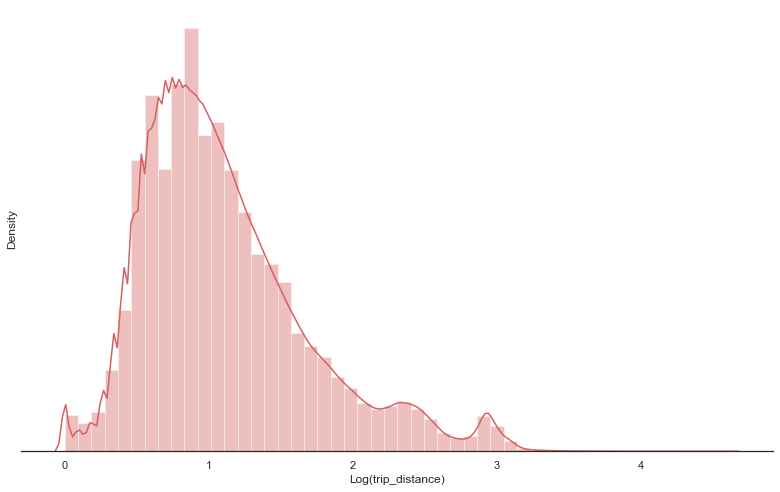

In [10]:
%matplotlib inline
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(df['trip_distance'].values+1), axlabel = 'Log(trip_distance)', label = 'log(trip_distance)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

In [ ]:
# Show that each col is a numpy ndarray. Note how array size is NaN until we call compute.
# chunk sizes compte also shows how this is parallelized.
df['trip_distance'].values.compute_chunk_sizes()

In [6]:
# number of rows
numrows = df.shape[0].compute()
# number of columns
numcols = df.shape[1]
print("Number of rows {} number of columns {}".format(numrows, numcols))

Number of rows 14776617 number of columns 19


In [7]:
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).map(lambda x: x.total_seconds())

In [25]:
df['trip_duration'].describe().compute()

count   14776617.00000
mean         694.53914
std        24465.83116
min       -29589.00000
25%          360.00000
50%          555.00000
75%          886.00000
max     69924412.00000
Name: trip_duration, dtype: float64

In [8]:
duration_diff = np.abs(df['trip_duration'])

In [9]:
# clean up data as we see some dirty inputs
df = df[df['trip_duration'] <= 10000]
df = df[df['trip_duration'] >= 30]

In [10]:
df['trip_duration'].describe().compute()

count    1.471284e+07
mean     6.870160e+02
std      4.948729e+02
min      3.000000e+01
25%      3.600000e+02
50%      5.590000e+02
75%      8.900000e+02
max      9.989000e+03
Name: trip_duration, dtype: float64

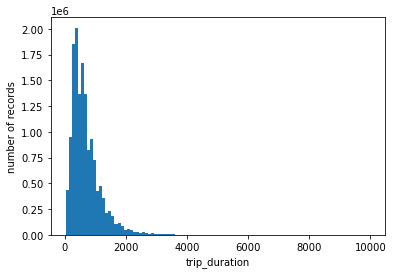

In [11]:
# note numpy -> ddf logic is slightly different. eg df[col].values vs df[col]
# visualizing whole dataset is a different fish to fry, we are just showing small ones for now.
plt.hist(df['trip_duration'], bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of records')
plt.show()

In [26]:
df['log_trip_duration'] = np.log(df['trip_duration'])


In [ ]:
plt.hist(df['log_trip_duration'], bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of records')
plt.show()
sns.distplot(df["log_trip_duration"], bins =100)

In [12]:
import xgboost as xgb

In [52]:
# we use dask random split
# train, test = df.random_split([0.7, 0.3])
train, test, validation = df.random_split([0.8, 0.1, 0.1], random_state=123)

In [17]:
train

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,log_trip_duration
npartitions=1,,,,,,,,,,,,,,,,,,,,,
,int64,datetime64[ns],datetime64[ns],int64,float64,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [18]:
# Chain them using dask, delay materialization...
# create dummy var out of labels.
train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,log_trip_duration
0,2,2013-01-01 00:39:00,2013-01-01 00:55:00,3,3.86000,1,None,238,116,2,...,0.50000,0.50000,0.00000,0.00000,0.00000,16.00000,None,None,960.00000,6.86693
1,2,2013-01-01 00:12:00,2013-01-01 00:16:00,5,0.00000,1,None,264,264,1,...,0.50000,0.50000,0.12000,0.00000,0.00000,4.62000,None,None,240.00000,5.48064
2,2,2013-01-01 00:02:00,2013-01-01 00:03:00,3,0.00000,1,None,264,264,1,...,0.50000,0.50000,0.25000,0.00000,0.00000,3.75000,None,None,60.00000,4.09434
4,2,2013-01-01 00:03:00,2013-01-01 00:04:00,4,0.00000,1,None,264,264,1,...,0.50000,0.50000,0.07000,0.00000,0.00000,4.07000,None,None,60.00000,4.09434
5,2,2013-01-01 00:03:00,2013-01-01 00:04:00,3,0.00000,1,None,146,146,1,...,0.50000,0.50000,0.25000,0.00000,0.00000,3.75000,None,None,60.00000,4.09434


In [53]:
# We could've read it at categorical when reading the parquet as specified in dtypes.
# Or we  can do it here.
# unlike pandas, must be categorized before calling dummy.
train = train.categorize("VendorID")
test = test.categorize("VendorID")

In [54]:
train = train.categorize("VendorID")
train = train.categorize("passenger_count")
train = train.categorize("store_and_fwd_flag")


In [55]:
test = test.categorize("VendorID")
test = test.categorize("passenger_count")
test = test.categorize("store_and_fwd_flag")

In [56]:
vendor_train = dd.get_dummies(train, columns=["VendorID"], prefix='vi', prefix_sep='_')

In [57]:
test_train = dd.get_dummies(test, columns=["VendorID"], prefix='vi', prefix_sep='_')

In [33]:
vendor_train.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,log_trip_duration,vi_2,vi_1
0,2013-01-01 00:39:00,2013-01-01 00:55:00,3,3.86,1,NaN,238,116,2,15.0,...,0.00,0.0,0.0,16.00,None,None,960.0,6.866933,1,0
1,2013-01-01 00:12:00,2013-01-01 00:16:00,5,0.00,1,NaN,264,264,1,3.5,...,0.12,0.0,0.0,4.62,None,None,240.0,5.480639,1,0
2,2013-01-01 00:02:00,2013-01-01 00:03:00,3,0.00,1,NaN,264,264,1,2.5,...,0.25,0.0,0.0,3.75,None,None,60.0,4.094345,1,0
4,2013-01-01 00:03:00,2013-01-01 00:04:00,4,0.00,1,NaN,264,264,1,3.0,...,0.07,0.0,0.0,4.07,None,None,60.0,4.094345,1,0
5,2013-01-01 00:03:00,2013-01-01 00:04:00,3,0.00,1,NaN,146,146,1,2.5,...,0.25,0.0,0.0,3.75,None,None,60.0,4.094345,1,0


In [58]:
# Full list of categorical vars

vendor_train = dd.get_dummies(train, columns=["VendorID"], prefix='vi', prefix_sep='_')
vendor_test = dd.get_dummies(test, columns=["VendorID"], prefix='vi', prefix_sep='_')

passenger_count_train = dd.get_dummies(train, columns = ['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test =dd.get_dummies(test, columns= ['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = dd.get_dummies(train, columns = ['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = dd.get_dummies(test, columns=['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
# cluster_pickup_train = dd.get_dummies(train, columns = ['pickup_cluster'], prefix='p', prefix_sep='_')
# cluster_pickup_test = dd.get_dummies(test, columns=['pickup_cluster'], prefix='p', prefix_sep='_')
# cluster_dropoff_train = dd.get_dummies(train, columns = 'dropoff_cluster'], prefix='d', prefix_sep='_')
# cluster_dropoff_test = dd.get_dummies(test, columns=['dropoff_cluster'], prefix='d', prefix_sep='_')

# month_train = dd.get_dummies(train, columns = ['Month'], prefix='m', prefix_sep='_')
# month_test = dd.get_dummies(test, columns=['Month'], prefix='m', prefix_sep='_')
# dom_train = dd.get_dummies(train, columns = ['DayofMonth'], prefix='dom', prefix_sep='_')
# dom_test = dd.get_dummies(test, columns=['DayofMonth'], prefix='dom', prefix_sep='_')
# hour_train = dd.get_dummies(train, columns = ['Hour'], prefix='h', prefix_sep='_')
# hour_test = dd.get_dummies(test, columns=['Hour'], prefix='h', prefix_sep='_')
# dow_train = dd.get_dummies(train, columns = ['dayofweek'], prefix='dow', prefix_sep='_')
# dow_test = dd.get_dummies(test, columns=['dayofweek'], prefix='dow', prefix_sep='_')

In [73]:
# enrich the datetime into month/ hour / day, and turn it into dummy
train['Month'] = train['tpep_pickup_datetime'].dt.month
# test['Month'] = (test['tpep_pickup_datetime']).map(lambda x: x.month)


In [75]:
# test.groupby('Month').count().compute()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,log_trip_duration
Month,,,,,,,,,,,,,,,,,,,,,
1,1469717,1469717,1469717,1469717,1469717,1469717,740846,1469717,1469717,1469717,...,1469717,1469717,1469717,1469717,1469717,1469717,0,0,1469717,1469717


In [77]:
train['DayofMonth'] = train['tpep_pickup_datetime'].dt.day
test['DayofMonth'] = test['tpep_pickup_datetime'].dt.day


In [78]:
test.groupby('DayofMonth').count().compute()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,log_trip_duration,Month
DayofMonth,,,,,,,,,,,,,,,,,,,,,
1,40749,40749,40749,40749,40749,40749,19724,40749,40749,40749,...,40749,40749,40749,40749,40749,0,0,40749,40749,40749
2,38834,38834,38834,38834,38834,38834,19273,38834,38834,38834,...,38834,38834,38834,38834,38834,0,0,38834,38834,38834
3,43953,43953,43953,43953,43953,43953,22025,43953,43953,43953,...,43953,43953,43953,43953,43953,0,0,43953,43953,43953
4,47864,47864,47864,47864,47864,47864,24142,47864,47864,47864,...,47864,47864,47864,47864,47864,0,0,47864,47864,47864
5,47052,47052,47052,47052,47052,47052,23759,47052,47052,47052,...,47052,47052,47052,47052,47052,0,0,47052,47052,47052
6,40160,40160,40160,40160,40160,40160,20679,40160,40160,40160,...,40160,40160,40160,40160,40160,0,0,40160,40160,40160
7,40600,40600,40600,40600,40600,40600,20862,40600,40600,40600,...,40600,40600,40600,40600,40600,0,0,40600,40600,40600
8,44004,44004,44004,44004,44004,44004,22268,44004,44004,44004,...,44004,44004,44004,44004,44004,0,0,44004,44004,44004
9,45440,45440,45440,45440,45440,45440,22992,45440,45440,45440,...,45440,45440,45440,45440,45440,0,0,45440,45440,45440


In [79]:
test.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,log_trip_duration,Month,DayofMonth
7,2,2013-01-01 00:06:00,2013-01-01 00:09:00,4,0.00,1,NaN,146,146,1,...,0.15,0.0,0.0,5.15,None,None,180.0,5.192957,1,1
13,2,2013-01-01 00:36:00,2013-01-01 00:46:00,1,1.97,1,NaN,249,13,1,...,1.50,0.0,0.0,11.50,None,None,600.0,6.396930,1,1
18,1,2013-01-01 00:07:08,2013-01-01 00:30:15,1,3.20,1,N,17,37,1,...,3.00,0.0,0.0,18.00,None,None,1387.0,7.234898,1,1
20,1,2013-01-01 00:55:51,2013-01-01 01:21:54,4,3.80,1,N,256,36,2,...,0.00,0.0,0.0,17.50,None,None,1563.0,7.354362,1,1
29,1,2013-01-01 00:13:34,2013-01-01 00:18:57,2,0.80,1,N,262,236,2,...,0.00,0.0,0.0,6.50,None,None,323.0,5.777652,1,1


In [81]:
train['Hour'] = train['tpep_pickup_datetime'].dt.hour
test['Hour'] = test['tpep_pickup_datetime'].dt.hour


In [82]:
train['dayofweek'] = train['tpep_pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['tpep_pickup_datetime'].dt.dayofweek


In [ ]:


train.categorize("Month")
test.categorize("Month")

train.categorize("DayofMonth")
test.categorize("DayofMonth")

train.categorize("dayofweek")
test.categorize("dayofweek")

month_train = dd.get_dummies(train, columns = ['dayofweek'], prefix='m', prefix_sep='_')
month_test = dd.get_dummies(test, columns=['dayofweek'], prefix='m', prefix_sep='_')

dom_train = dd.get_dummies(train, columns = ['dayofweek'], prefix='dom', prefix_sep='_')
dom_test = dd.get_dummies(test, columns=['dayofweek'], prefix='dom', prefix_sep='_')

hour_train = dd.get_dummies(train, columns = ['dayofweek'], prefix='h', prefix_sep='_')
hour_test = dd.get_dummies(test, columns=['dayofweek'], prefix='h', prefix_sep='_')

dow_train = dd.get_dummies(train, columns = ['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = dd.get_dummies(test, columns=['dayofweek'], prefix='dow', prefix_sep='_')

In [ ]:
# vendor_test = dd.get_dummies(test, columns=["VendorID"], prefix='vi', prefix_sep='_')

In [ ]:
# calculate and add average speed col
train.loc[:, 'avg_speed_h'] = 1000 * train['trip_distance'] / train['trip_duration']

In [ ]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

In [ ]:
train = train.drop(['VendorID','passenger_count','store_and_fwd_flag', 'Month','DayofMonth','Hour','dayofweek'], axis = 1)

In [36]:
test = test.drop(['VendorID','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek'], axis = 1)
train = train.drop(['tpep_dropoff_datetime', 'tpep_pickup_datetime', 'trip_duration', 'avg_speed_h'], axis = 1)

In [46]:
X_train = train.drop(['log_trip_duration'], axis=1)


In [47]:
Y_train = train["log_trip_duration"]
X_test = test.drop(['log_trip_duration'], axis=1)
Y_test = test["log_trip_duration"]

In [49]:
dtrain = xgb.DMatrix(X_train, label=Y_train)

In [51]:
dvalid = xgb.DMatrix(X_test, label=Y_test)

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
# Add indicator variables

Train_Master = pd.concat([train,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                         month_train,
                         dom_train,
                          hour_test,
                          dow_train
                         ], axis=1)

In [ ]:
Test_master = pd.concat([test, 
                         vendor_train,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         month_test,
                         dom_test,
                          hour_test,
                          dow_test], axis=1)

In [50]:

dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
dtrain = xgb.DMatrix(X_train, label=Y_train)

In [ ]:
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [ ]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

In [ ]:
sns.despine(left=True)
sns.distplot(
    np.log(df['trip_distance'].values+1),
    axlabel = 'Log(trip_distance)', label = 'log(trip_distance)', bins = 50, color="r")
plt.setp(axes, yticks=[])


Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x000001709DFAE700>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 40, in _remove
    self = selfref()
KeyboardInterrupt: 
Task exception was never retrieved
future: <Task finished name='Task-7347' coro=<Client._gather.<locals>.wait() done, defined at C:\ProgramData\Anaconda3\lib\site-packages\distributed\client.py:2006> exception=AllExit()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\distributed\client.py", line 2015, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

In [ ]:
# Train, Test = train_test_split(Train_Master[0:100000], test_size = 0.2)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [ ]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

In [ ]:
sns.despine(left=True)
sns.distplot(
    np.log(df['trip_distance'].values+1),
    axlabel = 'Log(trip_distance)', label = 'log(trip_distance)', bins = 50, color="r")
plt.setp(axes, yticks=[])


In [26]:
client.close()

In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:53543/status,
Dashboard: http://127.0.0.1:53543/status,Workers: 3
Total threads: 3,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53544,Workers: 3
Dashboard: http://127.0.0.1:53543/status,Total threads: 3
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:53574,Total threads: 1
Dashboard: http://127.0.0.1:53575/status,Memory: 0 B
Nanny: tcp://127.0.0.1:53547,
